In [1]:
using Base.Test
using Flux
using Plots
gr();
srand(1);

INFO: Precompiling module Flux.
INFO: Recompiling stale cache file /Users/davidwicks/.julia/lib/v0.6/Plots.ji for module Plots.
INFO: Recompiling stale cache file /Users/davidwicks/.julia/lib/v0.6/Hiccup.ji for module Hiccup.


In [27]:
struct DataPoint
    x::Number
    y::Number
    label::Int64
end

struct ModelParameters
    W1
    b1
    W2
    b2
end

In [28]:
planar_data = []
labels = Array{Int64, 2}(1, 0)
features = Array{Number, 2}(2, 0)
loops = 2
for θ in 0 : 0.05 : 2π
    r = 1 + 6 * abs(sin(loops * θ))
    t = θ / 2π
    interval = 1.0 / loops
    label = t % interval > interval / 2.0 ? 0 : 1
    dp = DataPoint(r * cos(θ), r * sin(θ), label)
    push!(planar_data, dp)
    features = hcat(features, [dp.x; dp.y])
    labels = hcat(labels, label)
end

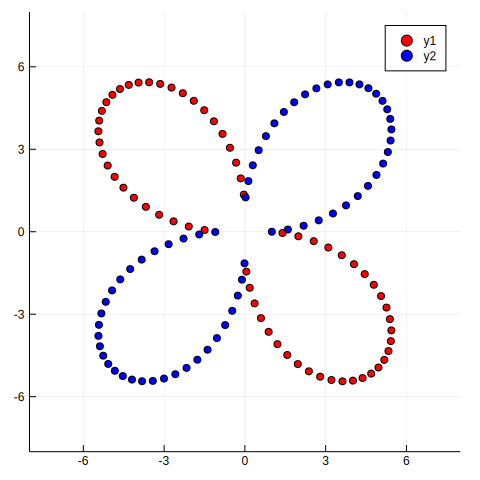

In [29]:
ax = [p.x for p in planar_data if p.label > 0.5]
ay = [p.y for p in planar_data if p.label > 0.5]
bx = [p.x for p in planar_data if p.label < 0.5]
by = [p.y for p in planar_data if p.label < 0.5]
scatter(bx, by, color=:red, size=(480, 480))
scatter!(ax, ay, color=:blue)
xlims!((-8, 8))
ylims!((-8, 8))

In [30]:
@testset "input data" begin
    @test ndims(features) == 2
    @test ndims(labels) == 2
    @test size(features, 2) == size(labels, 2)
end

Test Summary: | Pass  Total
input data    |    3      3


Base.Test.DefaultTestSet("input data", Any[], 3, false)

## Simple neural network learning

Initialize weights and biases in matrices.

In [44]:
sigmoid(x) = 1 / (1 + exp(-x))
local_tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

function forward_propagation(X, params::ModelParameters)
    Z1 = params.W1 * X .+ params.b1
    A1 = local_tanh.(Z1)
    Z2 = params.W2 * A1 .+ params.b2
    A2 = sigmoid.(Z2)
    
    return A2[1], Dict(["Z1" => Z1, "Z2" => Z2, "A1" => A1, "A2" => A2])
end

function compute_cost(Y, Ŷ)
    const m = length(Y) # m is our number of samples
    logprobs = (log.(Ŷ) .* Y + log.(1 - Ŷ)) .* (1 - Y)
    -sum(logprobs) / m
end

# Calculates the derivatives of our functions at each point in the network
# Knowing the derivatives, we can shift the values of the weights to adjust
# the output of each function to nudge results toward our desired outcome
function backward_propagation(X, Y, cache, params::ModelParameters)
    A1 = cache["A1"]
    A2 = cache["A2"]
    const m = length(Y) # m is our number of samples
    
    dZ2 = A2 - Y
    dW2 = dZ2 * transpose(A1) / m
    db2 = sum(dZ2, 2) / m
    dZ1 = (transpose(params.W2) * dZ2) .* (1 .- A1.^2)
    dW1 = dZ1 * transpose(X) / m
    db1 = sum(dZ1, 2) / m
    return Dict(["dW1" => dW1, "db1" => db1, "dW2" => dW2, "db2" => db2])
end

function update_parameters(params::ModelParameters, gradients, learning_rate=1.2)
    dW1 = gradients["dW1"]
    dW2 = gradients["dW2"]
    db1 = gradients["db1"]
    db2 = gradients["db2"]
    
    W1 = params.W1 - learning_rate * dW1
    W2 = params.W2 - learning_rate * dW2
    b1 = params.b1 - learning_rate * db1
    b2 = params.b2 - learning_rate * db2
    return ModelParameters(W1, b1, W2, b2)
end
;

In [45]:
costs = []
parameters = ModelParameters(
    rand(6, 2) * 0.01,
    zeros(6, 1),
    rand(1, 6) * 0.01,
    zeros(1, 1)
)
for i in 1:500
    Ŷ, cache = forward_propagation(features, parameters);
    push!(costs, compute_cost(labels, Ŷ))   
    gradients = backward_propagation(features, labels, cache, parameters)
    parameters = update_parameters(parameters, gradients, 0.01)
end


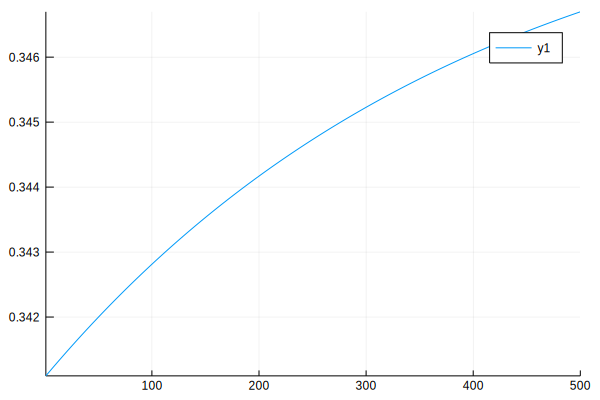

In [46]:
plot(1:length(costs), costs)

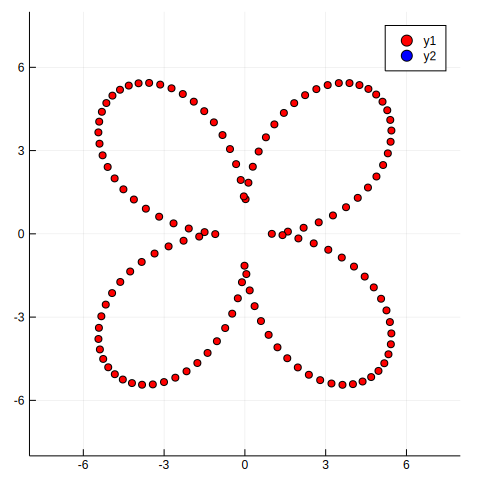

In [47]:
oax = [p.x for p in planar_data if forward_propagation([p.x; p.y], parameters)[1] >= 0.5]
oay = [p.y for p in planar_data if forward_propagation([p.x; p.y], parameters)[1] >= 0.5]
obx = [p.x for p in planar_data if forward_propagation([p.x; p.y], parameters)[1] < 0.5]
oby = [p.y for p in planar_data if forward_propagation([p.x; p.y], parameters)[1] < 0.5]
                                                
scatter(oax, oay, color=:red, size=(480, 480))
scatter!(obx, oby, color=:blue)
xlims!((-8, 8))
ylims!((-8, 8))                                       

In [67]:
function plot_decision_boundary(params::ModelParameters)
    ax = []; bx = []; ay = []; by = []
    
    for x in -8:0.5:8
        for y in -8:0.5:8
            guess, cache = forward_propagation([x; y], params)
            if(guess >= 0.5)
                push!(ax, x) 
                push!(ay, y)
            else
                push!(bx, x)
                push!(by, y)
            end
        end
    end
                                                
    scatter(ax, ay, color=:red, size=(480, 480))
    scatter!(bx, by, color=:blue)
    xlims!((-8, 8))
    ylims!((-8, 8))
end
;

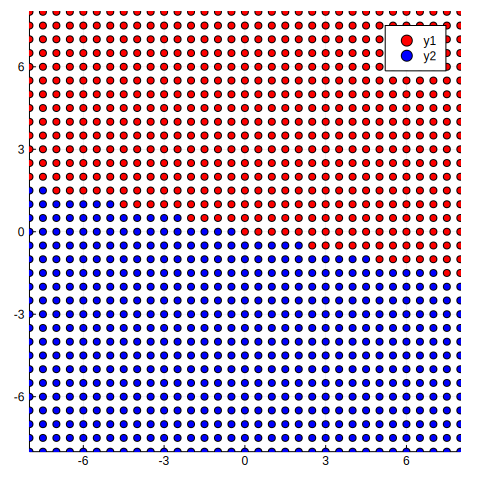

In [69]:
params = ModelParameters(
    rand(4, 2) * 0.01,
    zeros(4, 1),
    rand(1, 4) * 0.001,
    zeros(1, 1)
)
plot_decision_boundary(params)

In [12]:
v = [1 2 3
     4 5 6
     7 8 9]
# sum rows
sum(v, 2)

3×1 Array{Int64,2}:
  6
 15
 24

# Using Flux ML Library

In [6]:
W = rand(2, 5)
b = rand(2)
predict(x) = W*x .+ b
loss(x, y) = sum((predict(x) .- y).^2)

x, y = rand(5), rand(2)
loss(x, y)

5.2277613561790215

In [7]:
using Flux.Tracker
W = param(W)
b = param(b)
l = loss(x, y)

back!(l)

In [14]:
W.grad
W.data .-= 0.1(W.grad)
loss(x, y)

0.7893214048903638 (tracked)

In [18]:
W1 = param(rand(3, 5))
b1 = param(rand(3))
layer1(x) = W1 * x .+ b1

W2 = param(rand(2, 3))
b2 = param(rand(2))
layer2(x) = W2 * x .+ b2

model(x) = layer2(σ.(layer1(x)))
model(rand(5))

Tracked 2-element Array{Float64,1}:
 1.65112
 1.59667

In [27]:
function linear(in, out)
    W = param(randn(out, in))
    b = param(randn(out))
    x -> W * x .+ b
end

linear1 = linear(5, 3)
linear2 = linear(3, 2)

model(x) = linear2(σ.(linear1(x)))

model(x)

Tracked 2-element Array{Float64,1}:
  0.780217
 -0.566871

In [30]:
struct Affine
    W
    b
end

Affine(in::Integer, out::Integer) =
    Affine(param(randn(out, in)), param(randn(out)))

(m::Affine)(x) = m.W * x .+ m.b

a = Affine(10, 5)
a(rand(10))

Tracked 5-element Array{Float64,1}:
  0.586896 
 -2.24762  
 -0.808062 
 -0.718568 
  0.0392777

In [31]:
model2 = Chain(
    Dense(10, 5, σ),
    Dense(5, 2),
    softmax)

model2(rand(10))

Tracked 2-element Array{Float64,1}:
 0.239738
 0.760262